In [43]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from statsmodels.tsa.seasonal import STL,seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_process import arma_generate_sample

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error,mean_absolute_error


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

A moving average process, or the moving average (MA) model, states that the current value is linearly dependent on the current and past error terms. The error terms are assumed to be mutually independent and normally distributed, just like white noise.

A moving average model is denoted as MA(q), where q is the order. The model expresses the present value as a linear combination of the mean of the series μ, the present error term ϵt, and past error terms ϵt–q. The magnitude of the impact of past errors on the present value is quantified using a coefficient denoted as θq. Mathematically, we express a general moving average process of order q as in equation 4.1.

yt = μ + ϵt + θ1ϵt–1 + θ2ϵt–2 +⋅⋅⋅+ θqϵt–q

Equation 4.1

Moving average process

In a moving average (MA) process, the current value depends linearly on the mean of the series, the current error term, and past error terms.

The moving average model is denoted as MA(q), where q is the order. The general expression of an MA(q) model is

yt = μ + ϵt + θ1ϵt–1 + θ2ϵt–2 +⋅⋅⋅+ θqϵt–q

The order q of the moving average model determines the number of past error terms that affect the present value. For example, if it is of order 1, meaning that we have an MA(1) process, the model is expressed as in equation 4.2. Here we can see that the present value yt is dependent on the mean μ, the present error term ϵt, and the error term at the previous timestep θ1ϵt–1.

yt = μ + ϵt + θ1ϵt–1

Equation 4.3

Hence, we can see how the order q of the MA(q) process affects the number of past error terms that must be included in the model. The larger q is, the more past error terms affect the present value. Therefore, it is important to determine the order of the moving average process in order to fit the appropriate model—if we have a second-order moving average process, then a second-order moving average model will be used for forecasting.

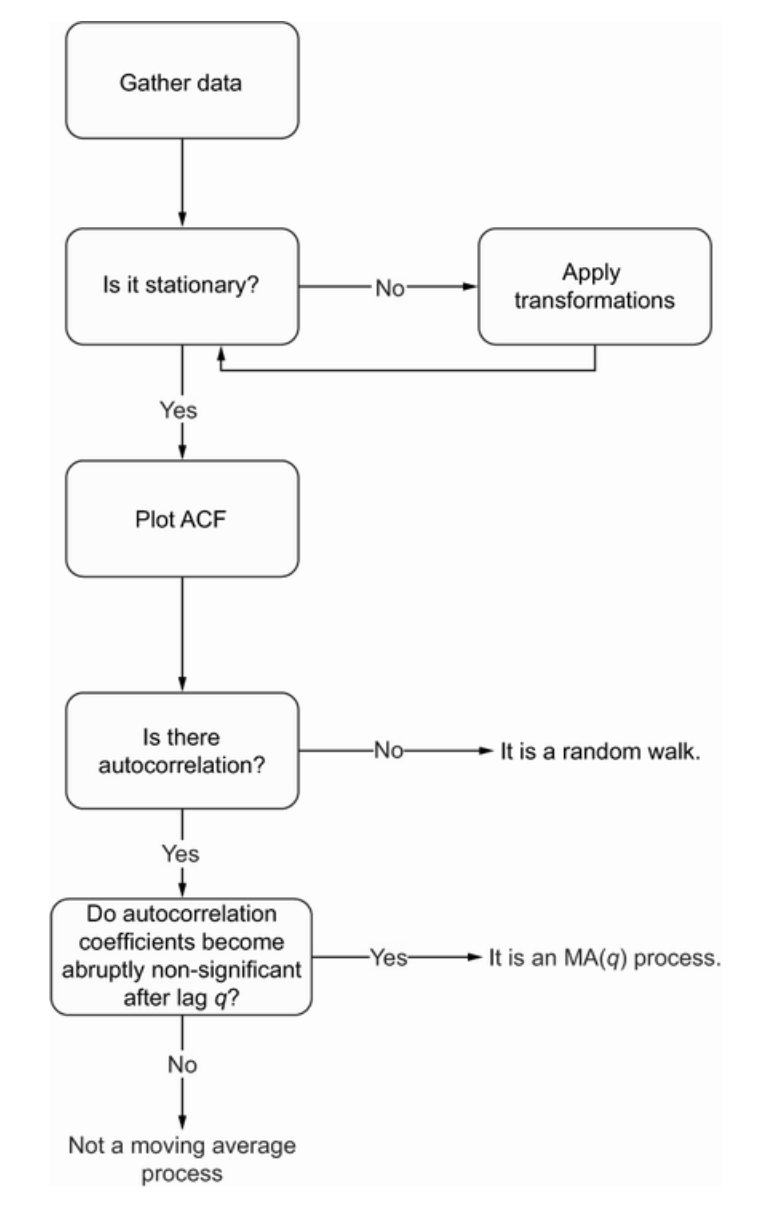

In [3]:
data=pd.read_csv("https://raw.githubusercontent.com/marcopeix/TimeSeriesForecastingInPython/master/data/widget_sales.csv")

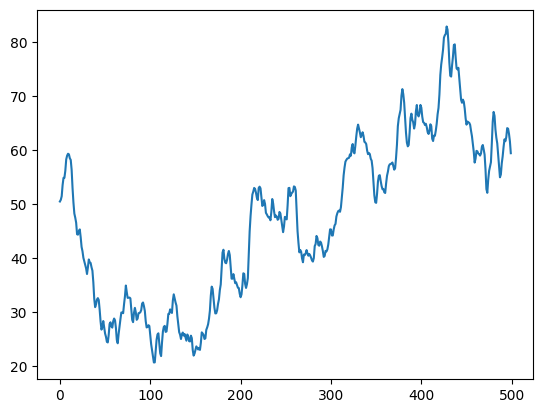

In [4]:
plt.plot(data['widget_sales'])

# Checking the stationary test

In [5]:
result = adfuller(data)

# Extracting the ADF test statistics and p-value
adf_stat = result[0]
p_value = result[1]

# Printing the results
print("ADF Statistic:", adf_stat)
print("p-value:", p_value)

ADF Statistic: -1.5121662069359048
p-value: 0.5274845352272605


since it is having p value is garter than the 0.05 we cannot reh=ject the null hypothysis so it is not stationary

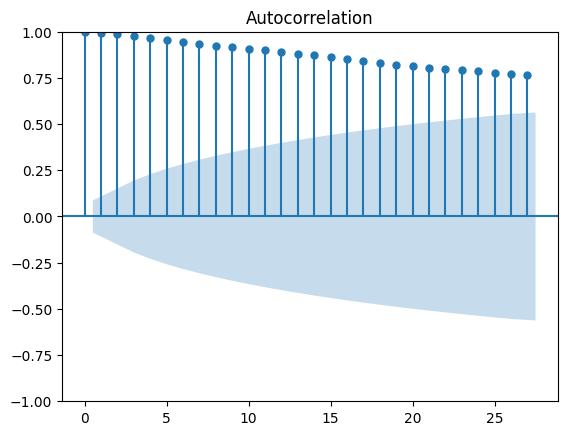

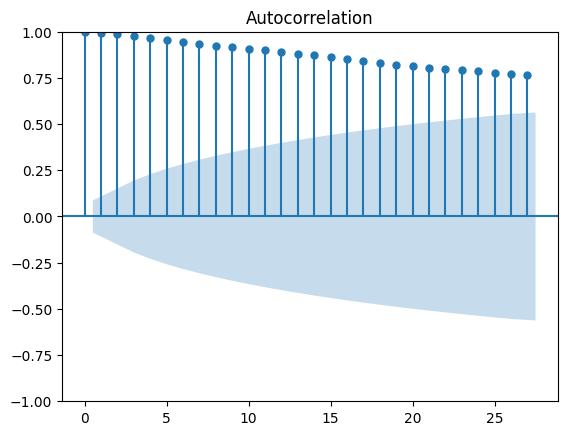

In [6]:
plot_acf(data)

From the above graph we can see that co relation is gardually decreasing so it is having MA since it is not having any pattern the it is having only the MA

# Differencing the data

In [7]:
data_diff=np.diff(data['widget_sales'],1)

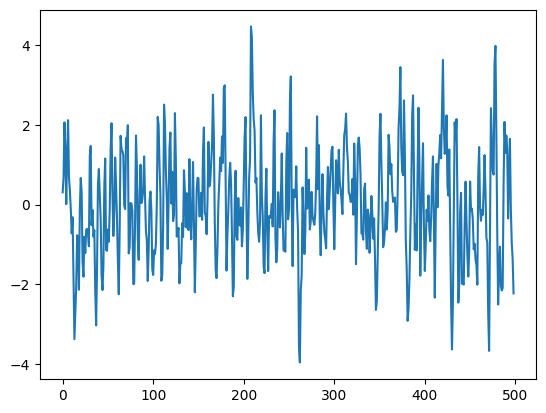

In [8]:
plt.plot(data_diff)

we can see that we have trmove the very high and long lows we have only random ness so we now we have to check weather it is a random walk or not

In [9]:
result = adfuller(data_diff)

# Extracting the ADF test statistics and p-value
adf_stat = result[0]
p_value = result[1]

# Printing the results
print("ADF Statistic:", adf_stat)
print("p-value:", p_value)

ADF Statistic: -10.576657780341959
p-value: 7.076922818587193e-19


by the above test we can know that the p vale is too low so we can conclude that we it is stationary

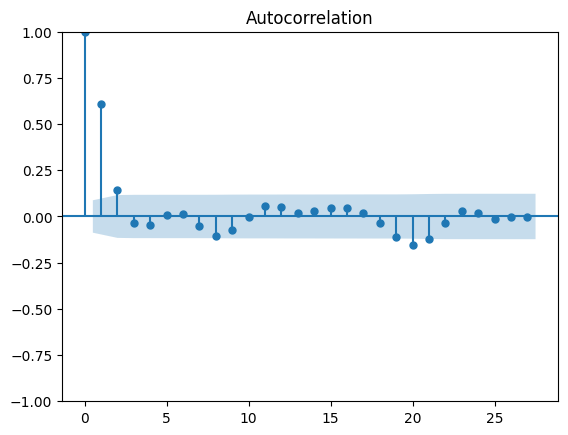

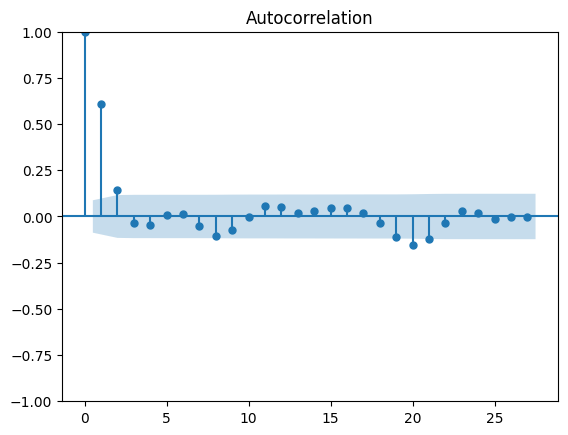

In [10]:
plot_acf(data_diff)

from the above plot we can know that after 2 lags thre is no sigifince lags so we can conclude that our q is 2 for MA

# Predicting the data for MA

In [11]:
data_diff_df=pd.DataFrame({'diff_data':data_diff})

In [12]:
train_data=data_diff_df[:int(0.9*len(data_diff_df))]
test_data=data_diff_df[int(0.9*len(data_diff_df)):]

In [29]:
def forecasting(df,train_len,window,method,horizon):
    total_len=train_len+horizon
    
    if method=='last':
        pred_last_value = []
        for i in range(train_len,total_len,window):
            last_value=df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
        return pred_last_value
    elif method=='mean':
        pred_last_mean_value=[]
        for i in range(train_len,total_len,window):
            mean_value=np.mean(df[:i].values)
            pred_last_mean_value.extend(mean_value for _ in range(window))
        return pred_last_mean_value
    else:
        ma_pred_data=[]
        for i in range(train_len,total_len,window):
            model = SARIMAX(df[:i], order=(0,0,2))
            model_fit = model.fit(disp=False)
            predictions = model_fit.get_prediction(0,i+window-1)
            oos_pred = predictions.predicted_mean.iloc[-window:] 
            ma_pred_data.extend(oos_pred)
        return ma_pred_data
    
        

In [30]:
train_len=len(train_data)
horizon=len(test_data)
window=2


last_pred_data=forecasting(data_diff_df,train_len,window,'last',horizon)
mean_pred_data=forecasting(data_diff_df,train_len,window,'mean',horizon)
ma_pred_data=forecasting(data_diff_df,train_len,window,'ma',horizon)

pred_df = test_data.copy()

pred_df['pred_mean'] = mean_pred_data
pred_df['pred_last_value'] = last_pred_data
pred_df['pred_MA'] = ma_pred_data

In [31]:
pred_df.head()

,diff_data,pred_mean,pred_last_value,pred_MA
449,-1.170131,0.034319,-1.803658,-1.078833
450,0.580967,0.034319,-1.803658,-0.273309
451,-0.144902,0.032861,0.580967,0.781223
452,-0.096564,0.032861,0.580967,0.234969
453,-0.372334,0.032183,-0.096564,0.168994


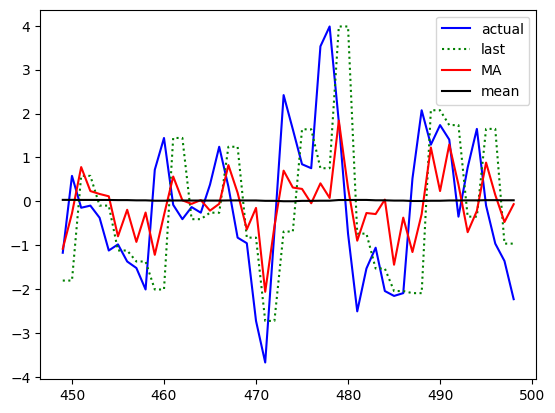

In [33]:
fig, ax = plt.subplots()

ax.plot(pred_df['diff_data'],'b-',label='actual')
ax.plot(pred_df['pred_last_value'],'g:',label='last')
ax.plot(pred_df['pred_MA'],'r-',label='MA')
ax.plot(pred_df['pred_mean'],'k-',label='mean')

ax.legend()


In [35]:
pred_df.head()

,diff_data,pred_mean,pred_last_value,pred_MA
449,-1.170131,0.034319,-1.803658,-1.078833
450,0.580967,0.034319,-1.803658,-0.273309
451,-0.144902,0.032861,0.580967,0.781223
452,-0.096564,0.032861,0.580967,0.234969
453,-0.372334,0.032183,-0.096564,0.168994


In [36]:
mse_mean = mean_squared_error(pred_df['diff_data'], pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['diff_data'], pred_df['pred_last_value'])
mse_MA = mean_squared_error(pred_df['diff_data'], pred_df['pred_MA'])

print(mse_mean, mse_last, mse_MA)

2.5606299456880537 3.2494260812249225 1.948171449776926


# Inverse Transformation

In [40]:
data['pred_widget_sales'] = pd.Series()          
data['pred_widget_sales'][450:] = data['widget_sales'].iloc[450] + pred_df['pred_MA'].cumsum()    

/tmp/ipykernel_34/2064736557.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  data['pred_widget_sales'] = pd.Series()


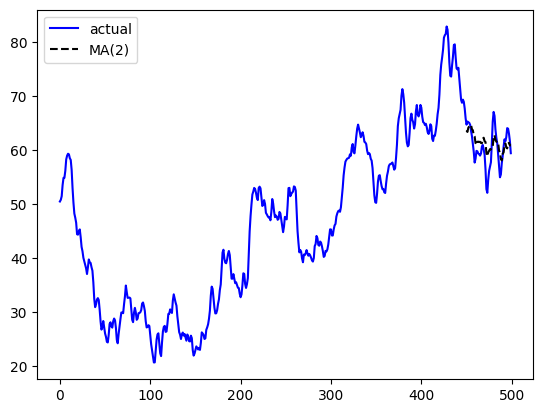

In [41]:
fig, ax = plt.subplots()

ax.plot(data['widget_sales'], 'b-', label='actual')
ax.plot(data['pred_widget_sales'], 'k--', label='MA(2)')

ax.legend(loc=2)

In [44]:
mae_MA_undiff = mean_absolute_error(data['widget_sales'].iloc[450:], data['pred_widget_sales'].iloc[450:])
 
print(mae_MA_undiff)


2.3244709244596082


This prints out an MAE of 2.32. Therefore, our predictions are, on average, off by $2,320, either above or below the actual value. Remember that our data has units of thousands of dollars, so we multiply the MAE by 1,000 to express the average absolute difference.